# descriptive stats (R)

### Requires: metadata.tsv (via Nextstrain) 

Goal: generate descriptive barplots (sequence counts by region, sample counts through time) for hmpxv1 subsampled genomes. 

### load libraries

In [143]:
library(tidyverse)
library(lubridate)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(scales)
library(ggbreak) 
library(patchwork)
library(anytime)

In [144]:
metadata_path <- '../out/beauti/meta.tsv'
og_path <- '../monkeypox-build/results/hmpxv1/good_metadata.tsv'

meta <- read_tsv(metadata_path)
og <- read_tsv(og_path)

Rows: 237 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (24): strain, accession, genbank_accession_rev, strain_original, date, r...
dbl  (4): coverage, missing_data, divergence, nonACGTN
lgl  (2): reverse, is_reverse_complement

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2790 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (23): strain, accession, genbank_accession_rev, strain_original, date, ...
dbl   (4): coverage, missing_data, divergence, nonACGTN
lgl   (2): reverse, is_reverse_complement
date  (1): date_submitted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_c

### filter metadata, reformat ambiguous dates

In [145]:
lin_b <- c('B.1',
 'B.1.1',
 'B.1.10',
 'B.1.11',
 'B.1.12',
 'B.1.13',
 'B.1.14',
 'B.1.2',
 'B.1.3',
 'B.1.4',
 'B.1.5',
 'B.1.6',
 'B.1.7',
 'B.1.8',
 'B.1.9') 

In [146]:
og <- og %>% filter(lineage %in% lin_b) %>%
    select('strain','date','region','country','lineage') %>%
    mutate(tmp = str_replace(country, 'UnitedKingdom', 'United Kingdom')) %>%
    filter(!grepl('-XX-XX', date)) %>% 
    mutate(tmp = str_replace(date, '-XX', '-01')) %>%
    mutate(tmp = str_replace(tmp, '/22','/2022')) %>% 
    mutate(date = anydate(tmp)) %>% 
    mutate(decimal = decimal_date(date)) %>% 
    mutate(month=month(date)) %>% 
    select(-tmp) 

meta <- meta %>% filter(lineage %in% lin_b) %>%
    select('strain','date','region','country','lineage') %>%
    mutate(tmp = str_replace(country, 'UnitedKingdom', 'United Kingdom')) %>%
    filter(!grepl('-XX-XX', date)) %>% 
    mutate(tmp = date) %>% 
    mutate(tmp = str_replace(date, '-XX', '-01')) %>%
    mutate(tmp = str_replace(tmp, '/22','/2022')) %>% 
    mutate(date = anydate(tmp)) %>% 
    mutate(decimal = decimal_date(date)) %>% 
    mutate(month=month(date)) %>% 
    select(-tmp)

In [147]:
meta$country <- factor(meta$country,
                       levels= c('Netherlands',
                                 'France',
                                 'United Kingdom',
                                 'Germany',
                                 'Switzerland',
                                 'Belgium',  
                                 'Austria',
                                
                                 'Slovenia',
                                 'Slovakia',
                                 
                                 'Finland',
                                 
                                 'Spain',
                                 'Portugal',
                                 'Italy',
                                 'Colombia',
                                 'Peru',
                                 
                                 'Canada',
                                 'USA'))

og$country <- factor(og$country)

### assign colors to regions and regions to samples

In [148]:
color_dic <- c('North America'= '#66c2a5',
               'South America'= '#fc8d62', 
               'Southern Europe'= '#8da0cb',
               'Northern Europe'= '#e78ac3',
               'Central/Eastern Europe'= '#a6d854',
               'Western Europe'= '#ffd92f')

loc <- tibble(country=levels(meta$country),
                   place= c(rep('Western Europe',7),
                              rep('Central/Eastern Europe',2),
                              'Northern Europe',
                              rep('Southern Europe', 3), 
                              rep('South America',2),
                              rep('North America',2)))

meta <- meta %>% left_join(loc, by = 'country')

In [149]:
my_theme <- function() {
    theme_classic() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=20, face="bold", vjust=2),
        axis.title.y = element_text(color="black", size=20, face="bold", vjust=2),
        axis.text=element_text(size=24),
        )
}

options(repr.plot.width=14, repr.plot.height=8)

## plot counts over time 

In [150]:
meta_counts <- meta %>% group_by(date, month) %>% count()
og_counts <- og %>% group_by(date,month) %>% count()

In [151]:
og_month <- og %>% group_by(month) %>% summarise(counts=n())
meta_month <- meta %>% group_by(month) %>% summarise(counts=n())

### plot counts from original dataset

Warning message in geom_histogram(position = "stack", stat = "identity", bins = 8, :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


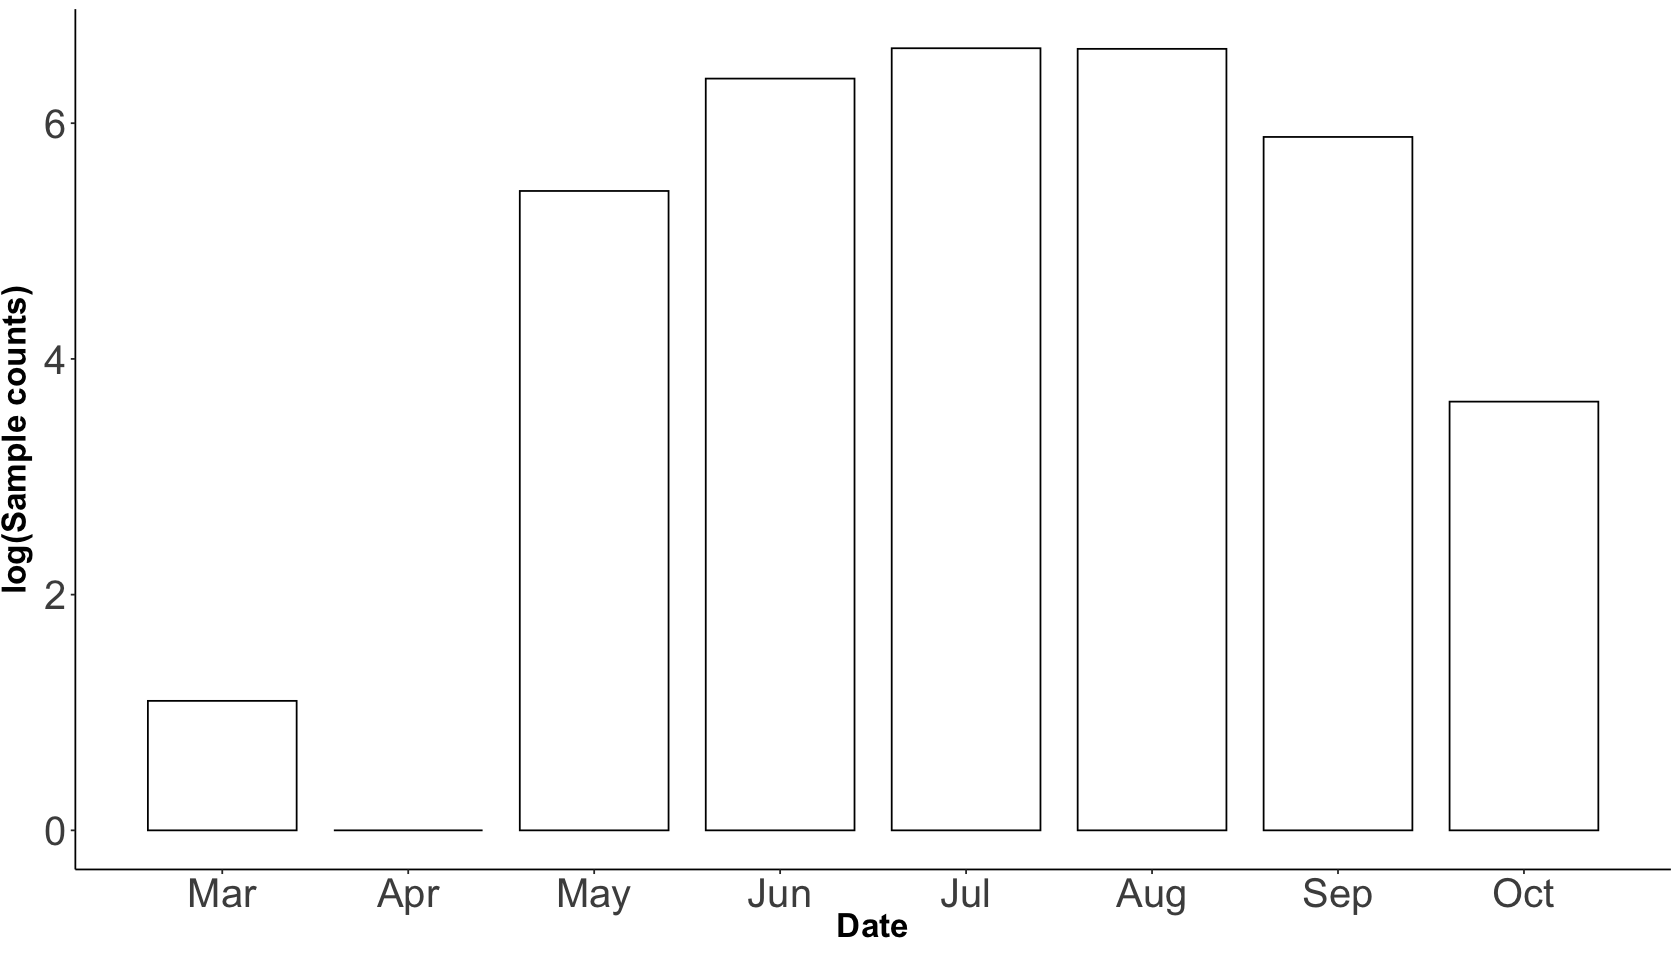

In [152]:
plot_og <- og_month %>% ggplot(aes(y=log(counts), x=month)) + 
         geom_histogram(position="stack", stat="identity", bins=8, width=0.8, fill='white', color='black') + 
         my_theme() + 
         scale_fill_manual(values=color_dic) + 
         ylab('log(Sample counts)') + xlab('Date') +
         scale_x_continuous(labels=function(x) month(x, label=TRUE), breaks = scales::pretty_breaks(n = 8))
                            
plot_og

### overlay counts from subsampled data

In [157]:
og_month %>% ggplot(aes(y=log(counts), x=month)) + 
         geom_histogram(position="stack", stat="identity", bins=8, width=0.8, fill='white', color='black') + 
         my_theme() + 
         scale_fill_manual(values=color_dic) + 
         ylab('log(Sample counts)') + xlab('2022') +
         scale_x_continuous(labels=function(x) month(x, label=TRUE), breaks = scales::pretty_breaks(n = 8)) + 
         geom_histogram(data=meta_month, stat = 'identity', fill='black',width=0.5)        

#ggsave('relative_counts.png', width = 14, height = 8)

Warning message in geom_histogram(position = "stack", stat = "identity", bins = 8, :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(data = meta_month, stat = "identity", fill = "black", :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
ERROR while rich displaying an object: Error in `geom_histogram()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 2nd layer.
Caused by error in `FUN()`:
! object 'counts' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, ha

ERROR: [1m[33mError[39m in `geom_histogram()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mℹ[39m Error occurred in the 2nd layer.
[1mCaused by error in `FUN()`:[22m
[33m![39m object 'counts' not found


### plot sample counts by region through time

Warning message in geom_histogram(position = "stack", stat = "identity", bins = 8):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message:
“Removed 2 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 2 rows containing missing values (`position_stack()`).”


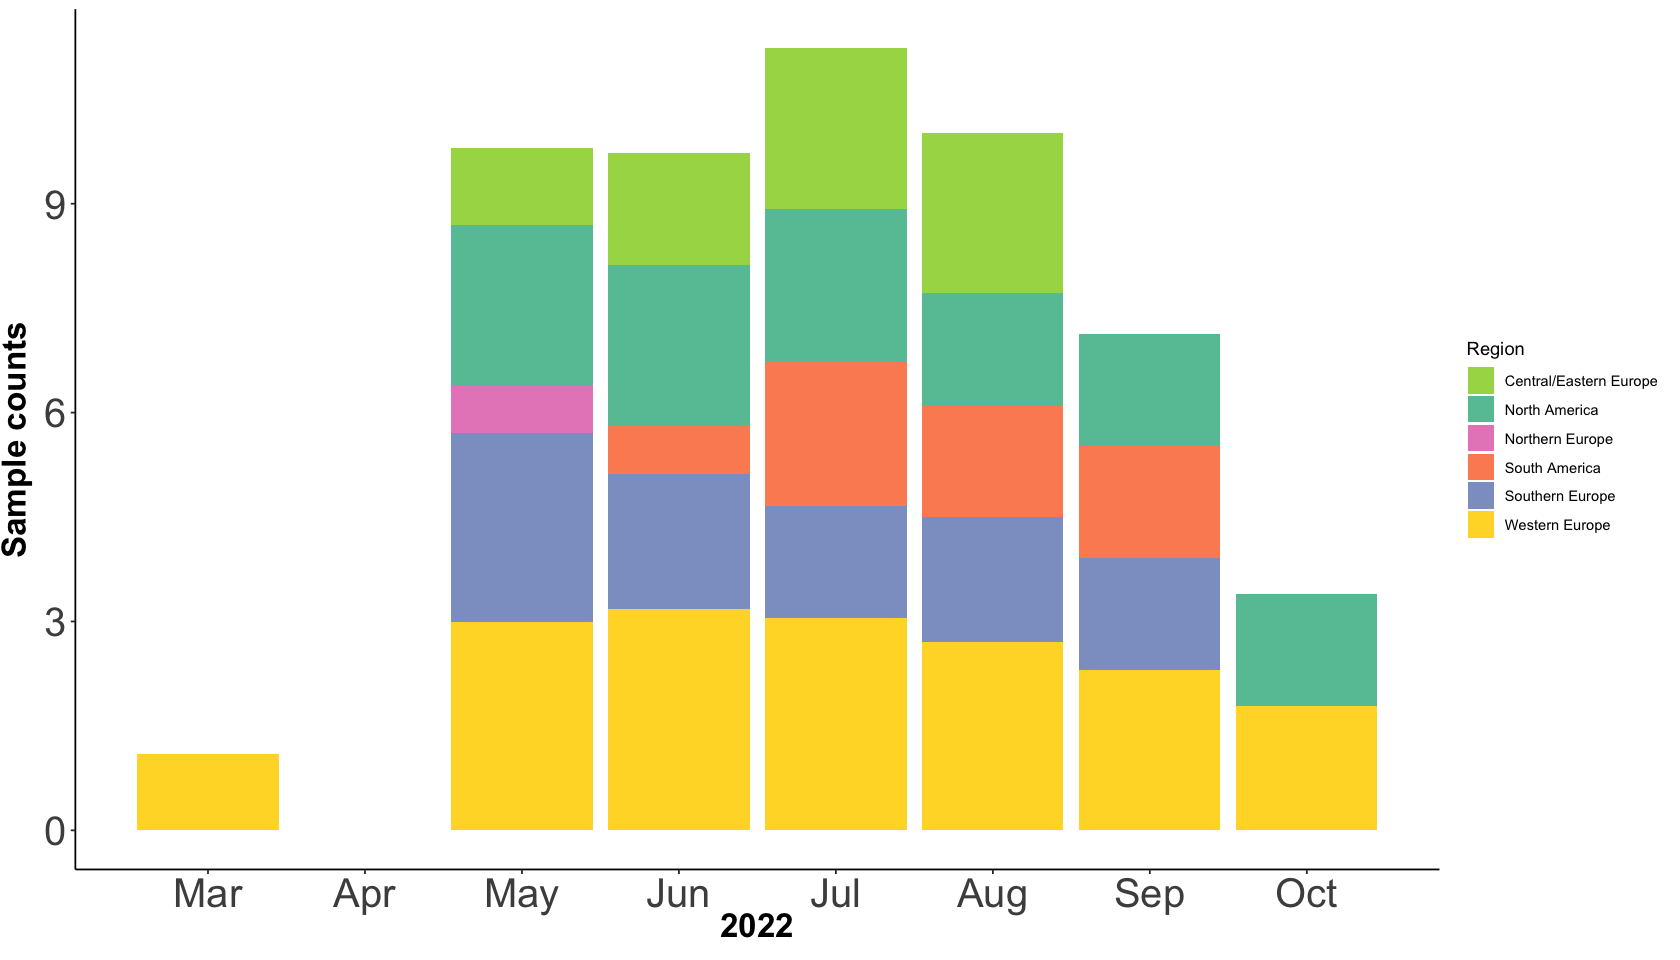

In [156]:
meta_grouped <- meta %>% group_by(month, place) %>% count()

meta_month <- meta %>% group_by(month) %>% count()

plot_meta <- meta %>% group_by(month, place) %>%
         count() %>%
         ggplot(aes(fill=place, y=log(n), x=month)) + 
         geom_histogram(position="stack", stat="identity", bins=8) + 
         my_theme() + 
         scale_fill_manual(values=color_dic) + 
         ylab('Sample counts') + xlab('2022') + guides(fill=guide_legend("Region"))+
         scale_x_continuous(labels=function(x) month(x, label=TRUE), breaks = scales::pretty_breaks(n = 8))
  
plot_meta 

#ggsave('sample_counts.png', width = 14, height = 8)